In [33]:
# Set up data getting functions for analysis
import os
os.chdir('C:\\\\Users\\\\rober\\\\PycharmProjects\\\\crusher\\\\src')
from utils.helper_functions.data_loading import get_odds_data, get_match_odds_data
from crusher.runner import RunnerCodeEnum as RCEnum
from crusher.market_type import MarketTypeCodeEnum as MTCEnum
from crusher.division import DivisionCodeEnum as DCEnum
from utils.db.database_manager import dbm
from crusher.item_freq_type import ItemFreqTypeCodeEnum as IFTCEnum
from utils.helper_functions import calculation as calc
from matplotlib import pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta
from utils.db.database_manager import dbm
from utils.helper_functions import preprocessing as pr
from orm.orm import ExchangeOddsSeries
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from utils.helper_functions import calculation as calc
import numpy as np


def get_nil_nil_odds_df(session):
    df = get_odds_data(session=session,
                       runner=RCEnum.SCORE_0_0,
                       divisions=[DCEnum.PREMIER_LEAGUE, DCEnum.CHAMPIONSHIP],
                       item_freq_type_code=IFTCEnum.MINUTE,
                       in_play=False)
    df = pr.add_event_uid_to_df(df)
    df = pr.drop_outlier_series_by_std(df)
    df = pr.drop_series_by_n_data_points(df, 40)
    return df

def get_match_odds_df(session):
    df_match_odds = get_match_odds_data(session=session,
                                      divisions=[DCEnum.PREMIER_LEAGUE],
                                      item_freq_type_code=IFTCEnum.MINUTE,
                                      in_play=False)
    df_match_odds = pr.drop_series_by_n_data_points(df_match_odds, 40)
    df_match_odds = pr.drop_outlier_series_by_std(df_match_odds, 3, value_col='team_a')
    df_match_odds = pr.add_event_uid_to_df(df_match_odds)
    df_match_odds['match_odds_diff'] = abs(df_match_odds['team_a'] - df_match_odds['team_b'])
    
    return df_match_odds

        
def get_joined_match_score_odds_df(session):
    df_score = get_nil_nil_odds_df(session)
    df_match = get_match_odds_df(session)
    df_score = df_score.drop('series_uid', axis=1)
    df_match = df_match.drop('series_uid', axis=1)

    df = pd.DataFrame(columns=['score_odds', 'match_odds_diff', 'event_uid'])
    for event_uid in df_match['event_uid'].unique():
        if event_uid not in df_score['event_uid'].unique():
            continue
        sub_match_df = df_match[df_match['event_uid'] == event_uid]
        sub_match_df = sub_match_df[['event_uid', 'match_odds_diff', 'published_datetime']]
        sub_match_df = sub_match_df.set_index('published_datetime')

        sub_score_df = df_score[df_score['event_uid'] == event_uid]
        sub_score_df = sub_score_df[['ltp', 'published_datetime']]
        sub_score_df = sub_score_df.set_index('published_datetime')

        joined_df = sub_score_df.join(sub_match_df, how='outer')
        joined_df[['ltp', 'match_odds_diff']] = joined_df[['ltp', 'match_odds_diff']].fillna(method='ffill')
        joined_df[['ltp', 'match_odds_diff']] = joined_df[['ltp', 'match_odds_diff']].fillna(method='bfill')
        joined_df['event_uid'] = event_uid
        joined_df = joined_df.rename(columns={'ltp': 'score_odds'})
        df = pd.concat([df, joined_df])

    return df

### Volitility
Examining volitility of the prices and how it varies by mean price.

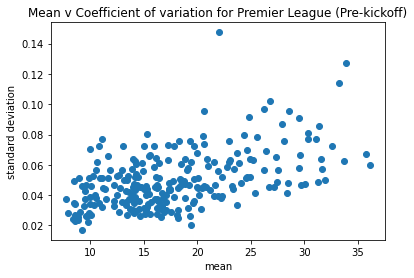

In [5]:
with dbm.get_managed_session() as session:
    df = get_nil_nil_odds_df(session)
value_counts = df['series_uid'].value_counts().reset_index().rename(columns={'series_uid': 'item_count',
                                                                             'index': 'series_uid'})
means = df.groupby('series_uid').mean().rename(columns={'ltp': 'series_mean'}).reset_index()
std_deviations = df.groupby('series_uid').std().rename(columns={'ltp': 'series_std_dev'}).reset_index()
comparison_df = pd.merge(means, std_deviations, on='series_uid')
comparison_df = pd.merge(comparison_df, value_counts, on='series_uid')
comparison_df['coefficients_of_variation'] = comparison_df['series_std_dev'] / comparison_df['series_mean']
plt.scatter(comparison_df['series_mean'], comparison_df['coefficients_of_variation'])
plt.ylabel('standard deviation')
plt.xlabel('mean')
plt.title("Mean v Coefficient of variation for Premier League (Pre-kickoff)")
plt.show()


### Relationship between 0-0 and match odds markets 

[[0.8723822]]
[13.30057989]
Correlation between match odds difference and 0-0 odds is:
[[1.         0.63116931]
 [0.63116931 1.        ]]


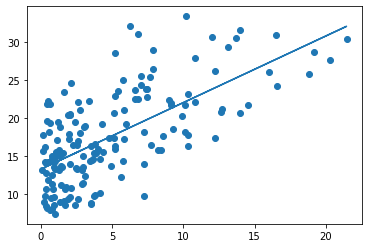

In [23]:
# Get match odds data
with dbm.get_managed_session() as session:
    df = get_joined_match_score_odds_df(session)
match_odds_diff_means = df.groupby('event_uid')['match_odds_diff'].mean()
score_odds_means = df.groupby('event_uid')['score_odds'].mean()
comparison_df = pd.DataFrame(match_odds_diff_means)
comparison_df['score_odds'] = score_odds_means
lr = LinearRegression()
lr.fit(comparison_df[['match_odds_diff']], comparison_df[['score_odds']])

plt.scatter(comparison_df['match_odds_diff'], comparison_df['score_odds'])
plt.plot(comparison_df['match_odds_diff'], lr.predict(comparison_df[['match_odds_diff']]))
plt.xlabel = 'match odds diff'
plt.ylabel = 'score odds'
print(lr.coef_)
print(lr.intercept_)

print('Correlation between match odds difference and 0-0 odds is:')
print(np.corrcoef(df['match_odds_diff'], df['score_odds']))
print('Correlation between match odds difference and 0-0 odds is:')
print(np.corrcoef(df['match_odds_diff'], df['score_odds']))


### Forecasting price drops based on match odds diff 

In [35]:
# get data
with dbm.get_managed_session() as session:
    df = get_joined_match_score_odds_df(session)
# iterate through events
for event_uid in df['event_uid'].unique():
    # iterate through the items looking for match odds diff changes
    sub_df = df[df['event_uid'] == event_uid]
    last_datetime = max(sub_df.index)
    start_datetime = last_datetime - relativedelta(days=2)
    sub_df = sub_df.sort_index(ascending=True)
    sub_df = sub_df[sub_df.index > start_datetime]
    sub_df = sub_df.resample('min').asfreq()
    sub_df = sub_df.fillna(method='ffill')
    sub_df['match_odds_diff_1_mins'] = sub_df['match_odds_diff'] - sub_df['match_odds_diff'].shift(1)
    sub_df['score_odds_diff_1_mins'] = sub_df['score_odds'] - sub_df['score_odds'].shift(1)
    sub_df = sub_df.dropna()
    back_ixs = []
    for ix, row in sub_df.iterrows():
        if row['match_odds_diff_1_mins'] < -0.4 and row['score_odds_diff_1_mins'] == 0:
            back_ixs.append(ix)
        else:
            continue
            
    if back_ixs:            
        back_odds = sub_df.loc[back_ixs[0]]['score_odds']
        df_after_ix = sub_df[sub_df.index > back_ixs[0]]
        values = df_after_ix['score_odds'].values
        lay_odds = next(v for v in values if v < back_odds)
        if lay_odds is not None:
            print(calc.equal_hedge(back_odds=back_odds, lay_odds=lay_odds, back_stake=100))
        else:
            lay_odds = df_after_ix.iloc[-1]['score_odds']
            print(calc.equal_hedge(back_odds=back_odds, lay_odds=lay_odds, back_stake=100))


2872
                     score_odds  match_odds_diff  event_uid  \
2018-08-16 12:34:00         8.8             0.81       2872   
2018-08-16 12:35:00         8.8             0.81       2872   
2018-08-16 12:36:00         8.8             0.81       2872   
2018-08-16 12:37:00         8.8             0.79       2872   
2018-08-16 12:38:00         8.8             0.79       2872   
...                         ...              ...        ...   
2018-08-18 12:24:00         9.2             0.86       2872   
2018-08-18 12:25:00         9.4             0.81       2872   
2018-08-18 12:26:00         9.2             0.81       2872   
2018-08-18 12:27:00         9.4             0.76       2872   
2018-08-18 12:28:00         9.4             0.78       2872   

                     match_odds_diff_1_mins  score_odds_diff_1_mins  
2018-08-16 12:34:00                    0.00                     0.0  
2018-08-16 12:35:00                    0.00                     0.0  
2018-08-16 12:36:00         

IndexError: list index out of range